# Introduction
The program is designed to analyze pictures of Pokémon TCG 1st gen cards. It aims to analyze the tradeoff between combinations of activation functions and optimizers, emphasizing the importance of well-performing variants in a pure, CNN-based image classification task.


<img src="Models Plot/model.jpg" alt="Example Image" width="900" height="600">

# Install Independences

In [1]:
!pip install visualkeras 
# !pip install tensorflow-addons # experimented with radam, we decided to go with nadam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 24.2 MB/s eta 0:00:00


In [2]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, PReLU
from keras.backend import clear_session, reset_uids
from keras import backend as K
from keras.optimizers import Nadam, Adam, AdamW

# FOR TRAINING 
from keras.utils import plot_model
import visualkeras


2024-02-04 21:57:41.778148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 21:57:41.778303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 21:57:41.932361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [4]:
list_physical_devices('GPU')

[]

# Pre-Processing Data: Splitting 

The dataset was taken from Kaggle and adapted to the scope of the project, as some 1st Pokémons were missing. In particular, there are around 25 to 50 images for each Pokemon, all with the Pokemon in the centre. Most (if not all) images have relatively high quality (correct labels, centred).
To train the models, we split the dataset into 8:2 for train and evaluation. So we have:
$$
\begin{equation}
\begin{aligned}
\text{TrainingSet} \approx 0.8 \times 0.8 \times \underbrace{151}_{\text{Number of Pokémon}} \times [25,50] \approx [2416, 4832] \\
\text{ValidationSet} \approx 0.8 \times 0.2 \times \underbrace{151}_{\text{Number of Pokémon}} \times [25,50] \approx [604, 1208]
\end{aligned}
\end{equation}
$$

In [1]:
def create_path(path):
  train_dir = path+"/Pokemon_train"
  test_dir =  path+"/Pokemon_test"
  os.system("mkdir " +train_dir)
  os.system("mkdir " +test_dir)
  return train_dir, test_dir

def splitting(data_path, train_path, test_path, perc):
  
  # folders Pokemon
  fold = sorted(os.listdir(data_path))
  for f in fold:
    # Take the pokemon directory by data_path
    pok_dir = data_path+ f + '/'

    # CREATE POKEMON FOLDER IN THE TEST SET
    if not os.path.isdir(test_path+f):
      os.makedirs(test_path+f)
    pok_file = os.listdir(data_path+f) # list with image of pokemon
  
    # Number of pokemon for the test set
    num_test = round(len(pok_file)* perc)
    # select randomly the image of pokemon for the test set
    img_pok_test = random.sample(pok_file, num_test)

    # We move the image into test set
    for pok_test in img_pok_test:
      shutil.move(pok_dir + pok_test, test_path + f + '/'+ pok_test )

    # CREATE POKEMON FOLDER IN THE TRAIN SET
    if not os.path.isdir(train_path+f):
      os.makedirs(train_path+f)
    
    pok_file = os.listdir(data_path+f) # list with image of pokemon
    # We move the remaining image into train set
    for pok_train in pok_file:
      shutil.move(pok_dir+ pok_train, train_path+f+'/'+pok_train)
      
  return  "Done we split the dataset into training set and validation set"

# DataLoader: Data Augmentation


Data augmentation is a technique used in deep learning to artificially increase the size and diversity of a training dataset by applying various transformations to the existing data samples. The goal of data augmentation is to improve the generalization and robustness of machine learning models by exposing them to a wider variety of data during training.

Data augmentation techniques commonly include:
- $\textbf{Rotation:}$ Rotating images by a certain degree (e.g., 90 degrees, 180 degrees) to simulate different viewpoints.

- $\textbf{Scaling:}$ Resizing images to different dimensions, either larger or smaller, to simulate different zoom levels.

- $\textbf{Shearing:}$ Applying a shearing transformation to skew the images along one of the axes.

- $\textbf{Zooming:}$ Zooming in or out of images to simulate different levels of magnification

- $\textbf{Flipping:}$ Mirroring images horizontally or vertically to simulate reflections.

In [5]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

### Early Stopping
Early Stopping involves monitoring the performance of a model on a separate validation dataset during training and stopping the training process once the performance on the validation dataset starts to degrade. Here's how early stopping works:
- **Training Phase**

    During the training phase, the model is trained on the training dataset using an optimization algorithm.
    
- **Validation Phase**

    After each epoch, the model's performance is evaluated on a separate validation dataset that the model hasn't seen during training.

- **Monitoring Performance**

    The performance metric (e.g., accuracy, loss) on the validation dataset is monitored. If the performance metric starts to degrade or fails to improve for a certain number of epochs, it indicates that the model is beginning to overfit the training data.
    
- **Stopping Criteria**

    Once the performance on the validation dataset fails to improve or begins to degrade for a specified number of consecutive epochs (known as the patience parameter), the training process is stopped early

### Reducing Learning Rate on Plateau
We used ReduceLROnPlateau, which is a scheduling technique that decreases the learning rate when the specified metric stops improving for longer than the patience number allows. Thus, the learning rate is kept the same as long as it improves the metric quantity, but the learning rate is reduced when the results run into stagnation, after a defined amount of epochs. This is applied before EarlyStopping to avoid abrupt interruption. The learning rate gets modified with:
$$
\begin{equation}
    New\_LR = factor * Old\_LR
\end{equation}

$$

with $\textbf{factor}$ being a real number.

In [6]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                                             patience=5, min_lr=0.001, 
                                                                             mode='min', verbose=1)],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                                         patience=5, min_lr=0.001, 
                                                                         mode='min', verbose=1)],
                                      epochs = num_epochs)

    return history, filepath, es

## Evaluation Metrics

Metrics help capture a business goal into the quantitative target and also Evaluation Metrics help organize machine learning team effort towards that target.

So Evaluation metrics are useful to measure how well your model is doing in terms of your desired performance level, in essence, it’s useful to quantify the gap.

### Accuracy
Accuracy is basically what is the fraction of all the examples that we got right, no matter what class they were that we predicted.
$$
\begin{equation}
\operatorname{Accuracy}(y, \hat{y})=\frac{1}{n_{\text {samples }}} \sum_{i=0}^{n_{\text {samples }}-1} 1\left(\hat{y}_i=y_i\right)
\end{equation}
$$

### Precision
Precision means among the examples that we predicted to be positive what fraction of them were positive.
$$
\begin{equation}
\text { Precision }=\frac{\text { TruePositive }}{\text { TruePositive }+ \text { FalsePositive }}
\end{equation}
$$

### Recall (Sensitivity)
What recall measures is if we were to use this classifier in deployment what fraction of all the actual positives are we going to recover
$$
\begin{equation}
\text { Recall }=\frac{\text { TruePositive }}{\text { TruePositive }+ \text { FalseNegative }}
\end{equation}
$$
The term sensitivity comes from epidemiology and in essence how sensitive this test is for detecting a certain condition.


### F1-Score
F1-score is the harmonic mean of precision and recall:
$$
\begin{equation}
\begin{aligned}
\frac{1}{\text { FScore }} & =\frac{1}{\text { Precision }}+\frac{1}{\text { Recall }} \\
\text { FScore } & =\frac{\text { Precision } * \text { Recall }}{\text { Precision }+ \text { Recall }}
\end{aligned}
\end{equation}
$$


In [8]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define F1 Function
def F1_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['f1_m'], color='teal', label='F1_score')
    plt.plot(hist.history['val_f1_m'], color='orange', label='val_F1_score')
    fig.suptitle('F1 Score', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Precision Function
def precision_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['precision_m'], color='teal', label='precision_score')
    plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_score')
    fig.suptitle('Precision', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Recall Function
def recall_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['recall_m'], color='teal', label='recall_score')
    plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_score')
    fig.suptitle('Recall', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    F1_function(hist)
    precision_function(hist)
    recall_function(hist)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))
    
    print("Train F1-Score = %.4f" % (metrics_train[2]))
    print("Train Precision = %.4f" % (metrics_train[3]))
    print("Train Recall = %.4f" % (metrics_train[4]))
    
    print("Test F1-Score = %.4f" % (metrics_val[2]))
    print("Test Precision = %.4f" % (metrics_val[3]))
    print("Test Recall = %.4f" % (metrics_val[4]))

# Models

### Convolutional Neural Network (CNN)

A Convolutional Neural Network (CNN) is a type of deep neural network designed to process and analyze visual data. CNNs have proven highly effective in tasks such as image recognition, object detection, and image classification. Key components of a CNN are:

- **Convolutional Layers**

    The core building blocks of a CNN are convolutional layers. These layers apply convolution operations to the input data using filters or kernels. Convolution helps the network learn features like edges, textures, and patterns in a spatially hierarchical manner.

- **Pooling (Subsampling) Layers**

    Pooling layers are used to reduce the spatial dimensions of the input data by down-sampling. Common pooling operations include max pooling, which retains the maximum value in a region, and average pooling, which computes the average value.

- **Fully Connected Layers**

    After several convolutional and pooling layers, fully connected layers are often added to the network. These layers connect every neuron to every neuron in the previous and subsequent layers, forming a dense layer. Fully connected layers are typically used for decision-making and classification.

- **Flattening**

    Before the fully connected layers, the output from the previous layers is flattened into a one-dimensional vector. This is necessary because fully connected layers require a one-dimensional input.

### Activation Functions
An activation function is a mathematical operation applied to the output of a neuron (or a node) in a neural network. It introduces non-linearity to the network, enabling it to learn complex patterns and relationships in the data. In this project, we focus on:
 -  ReLU activation function 
 -  PReLU (a piecewise-linear variant)
 -  GeLU (a non-linear variant)

### Optimizers

An optimizer is an algorithm used to adjust the parameters of the model during the training process. The primary goal of optimization is to minimize the error or loss function, allowing the neural network to make accurate predictions on new, unseen data. The optimizer is responsible for updating the model parameters based on the difference between these predictions and the actual target values. In this project, we focus on:
- Adam optimizer  
- AdamW optimizer
- RAdam optimizer


Each model had this structure with different combinations of activation functions and optimizers:
- 35 epochs
- 0.002 starting learning rate, reduced by the scheduler if needed, with factor = 0.8
- 32 batch size
- Two convolutional layers:
    - 64 filters, (5, 5) stride
    - 128 filters (3, 3) stride
- Two 2 x 2 max pooling layers
- A Final Dense Softmax layer to classify Pictures

## Model 1 - ReLU

The Rectified Linear Unit is one of the most popular activation functions because it's relatively simply defined: 
$$
\begin{equation}
    ReLU(x) = \max(0,x)
\end{equation}
$$

This serves the specific purpose of introducing a gentle non-linearity into the model, while still preserving piecewise linearity.

In [10]:
#%% ----- MODEL 1 -----
#defining model
def model_1a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier


In [11]:
#%% ----- MODEL 1 -----
#defining model
def model_1b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

In [12]:
#%% ----- MODEL 1 -----
#defining model
def model_1c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

## Model 2 - PReLU

PReLU, or Parametrized Linear Unit, is a variant of the classic ReLU, which features a small slope for negative values instead of being flat. The function receives a list of values that can either be positive or negative. All the negative values will be multiplied by the learned alpha value so they become close to zero.
$$
\begin{equation}
    PReLU(x) = \begin{cases}
    \alpha x & \text{if } x < 0\\
    x & \text{if } x \geq 0
\end{cases}
\end{equation}
$$
where $\alpha$ is a **learned array** with the same shape as x.


In [13]:
#%% ----- MODEL 2 -----
#Defining model
def model_2a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [14]:
#%% ----- MODEL 2 -----
#Defining model
def model_2b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [15]:
#%% ----- MODEL 2 -----
#Defining model
def model_2c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

## Model 3 - GeLU

GELU, or Gaussian Error Linear unit, is a non-linear variant of ReLU introduced in 2016 by Dan Hendrycks and Kevin Gimpel in the homonym paper. It's defined as:
$$
\begin{equation}
     GELU(x) = x\Phi(x)
\end{equation}
$$
 where $\Phi(X)$ is the standard Gaussian cumulative distribution function. 

In [16]:
#%% ----- MODEL 3 -----
#defining model
def model_3a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [17]:
#%% ----- MODEL 3 -----
#defining model
def model_3b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [18]:
#%% ----- MODEL 3 -----
#defining model
def model_3c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

# Training

## Paths

In [19]:
train_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/train'
test_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/validation'

## Training Model 1

In [20]:
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

In [21]:
neuralnetwork_cnn1a = model_1a(img_size1, num_classes= 151)
neuralnetwork_cnn1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [22]:
neuralnetwork_cnn1b = model_1b(img_size1, num_classes= 151)
neuralnetwork_cnn1b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

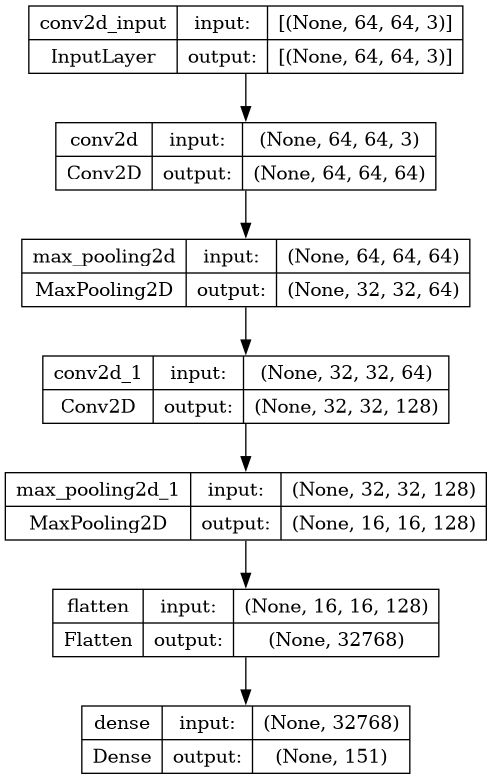

In [23]:
neuralnetwork_cnn1c = model_1c(img_size1, num_classes= 151)
neuralnetwork_cnn1c.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')

#models are all the same, plotting once
plot_model(neuralnetwork_cnn1c, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

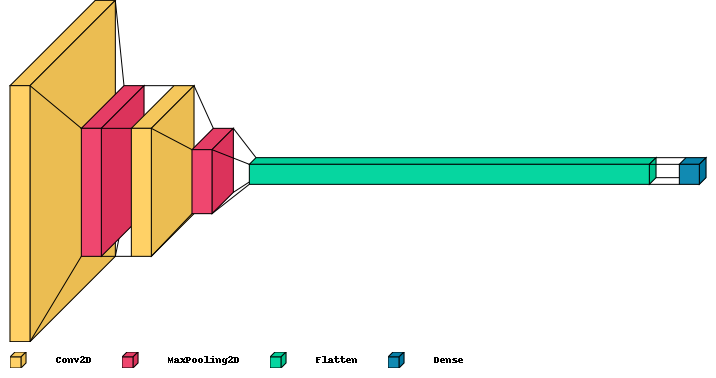

In [24]:
visualkeras.layered_view(neuralnetwork_cnn1c, legend = True, spacing = 30)

In [25]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [26]:
hist1a , fil1a, es1a = train_model(model=neuralnetwork_cnn1a, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=11, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 5.0521 - acc: 0.0073 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: loss improved from inf to 5.05206, saving model to model11.h5
219/219 [==============================] - 95s 429ms/step - loss: 5.0521 - acc: 0.0073 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.0176 - val_acc: 0.0062 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0020


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 5.0179 - acc: 0.0100 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2: loss improved from 5.05206 to 5.01789, saving model to model11.h5
219/219 [==============================] - 65s 298ms/step - loss: 5.0179 - acc: 0.0100 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.0130 - val_acc: 0.0083 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0020
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 4.9826 - acc: 0.0150 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 3: loss improved from 5.01789 to 4.98261, saving model to model11.h5
219/219 [==============================] - 65s 296ms/step - loss: 4.9826 - acc: 0.0150 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.9327 - val_acc: 0.0204 - val_f1_m: 0.0016 - val_precision_m: 0.0263 - val_reca

In [27]:
hist1b , fil1b, es1b = train_model(model=neuralnetwork_cnn1b, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=12, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 4.7046 - acc: 0.0450 - f1_m: 0.0022 - precision_m: 0.0365 - recall_m: 0.0011
Epoch 1: loss improved from inf to 4.70465, saving model to model12.h5
219/219 [==============================] - 69s 310ms/step - loss: 4.7046 - acc: 0.0450 - f1_m: 0.0022 - precision_m: 0.0365 - recall_m: 0.0011 - val_loss: 4.0945 - val_acc: 0.1240 - val_f1_m: 0.0242 - val_precision_m: 0.2818 - val_recall_m: 0.0127 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 3.3823 - acc: 0.2417 - f1_m: 0.1030 - precision_m: 0.5903 - recall_m: 0.0580
Epoch 2: loss improved from 4.70465 to 3.38232, saving model to model12.h5
219/219 [==============================] - 67s 306ms/step - loss: 3.3823 - acc: 0.2417 - f1_m: 0.1030 - precision_m: 0.5903 - recall_m: 0.0580 - val_loss: 2.5843 - val_acc: 0.4064 - val_f1_m: 0.2377 - val_precision_m: 0.7539 - val_recall_m: 0.1439 - lr: 0.0020
Epoch 3/35
219/219 [==================

In [28]:
hist1c , fil1c, es1c = train_model(model=neuralnetwork_cnn1c, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=13, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 4.3838 - acc: 0.0893 - f1_m: 0.0194 - precision_m: 0.1716 - recall_m: 0.0105
Epoch 1: loss improved from inf to 4.38383, saving model to model13.h5
219/219 [==============================] - 78s 350ms/step - loss: 4.3838 - acc: 0.0893 - f1_m: 0.0194 - precision_m: 0.1716 - recall_m: 0.0105 - val_loss: 3.2239 - val_acc: 0.2787 - val_f1_m: 0.1289 - val_precision_m: 0.7435 - val_recall_m: 0.0724 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.7076 - acc: 0.3763 - f1_m: 0.2684 - precision_m: 0.7350 - recall_m: 0.1695
Epoch 2: loss improved from 4.38383 to 2.70761, saving model to model13.h5
219/219 [==============================] - 76s 346ms/step - loss: 2.7076 - acc: 0.3763 - f1_m: 0.2684 - precision_m: 0.7350 - recall_m: 0.1695 - val_loss: 1.9497 - val_acc: 0.5329 - val_f1_m: 0.4471 - val_precision_m: 0.8271 - val_recall_m: 0.3125 - lr: 0.0020
Epoch 3/35
219/219 [==================

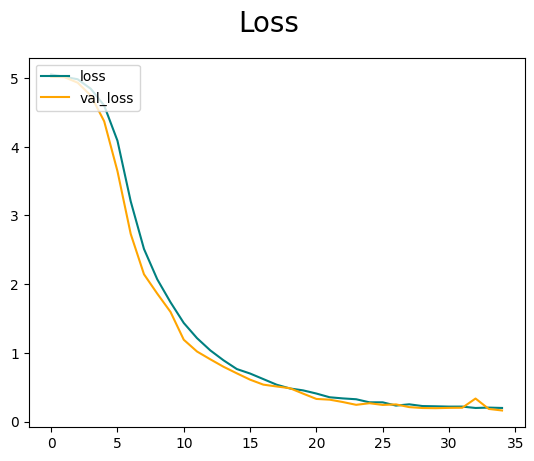

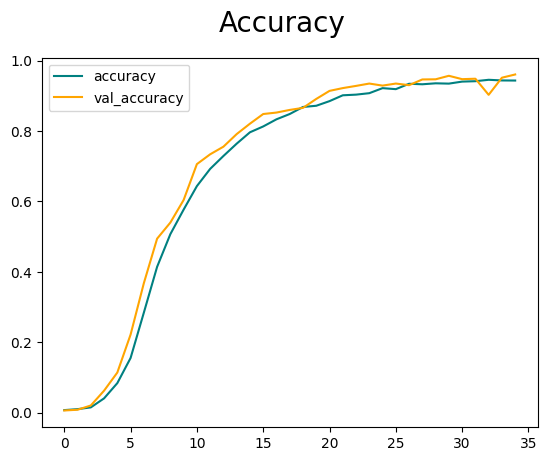

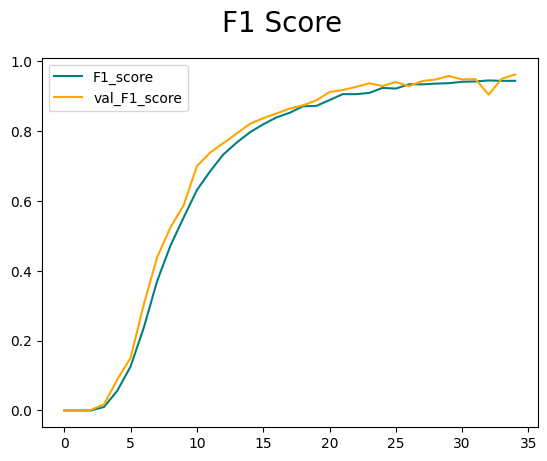

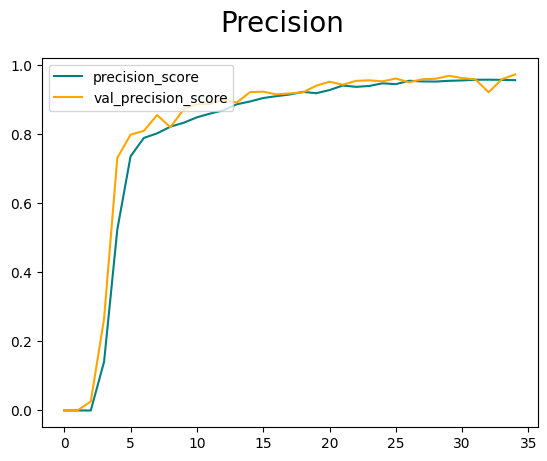

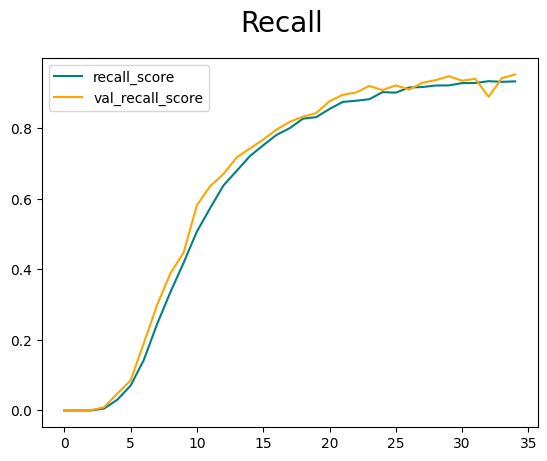

In [29]:
plot_history(hist=hist1a)

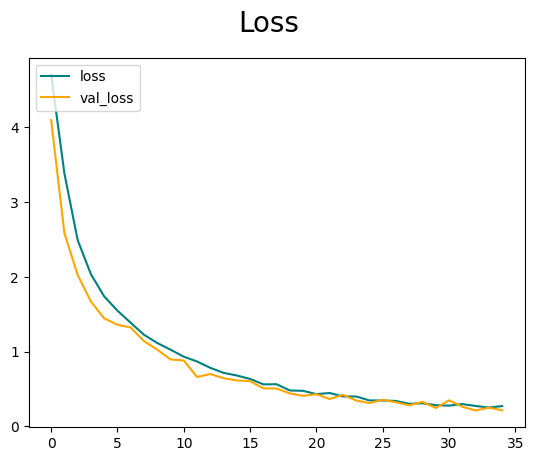

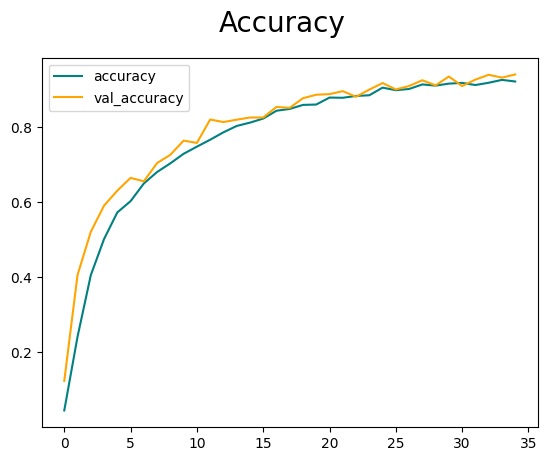

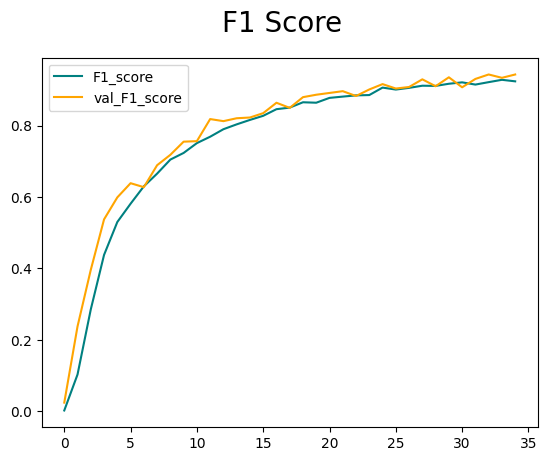

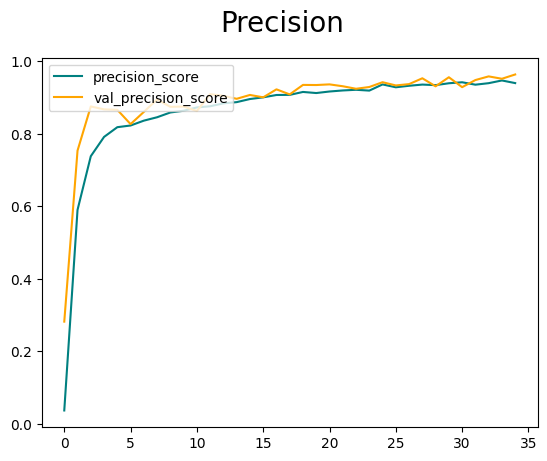

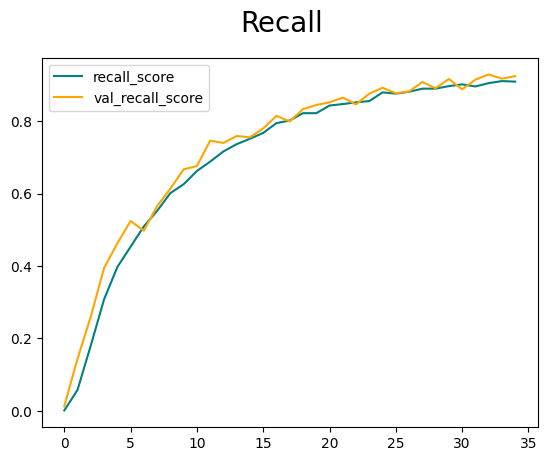

In [30]:
plot_history(hist=hist1b)

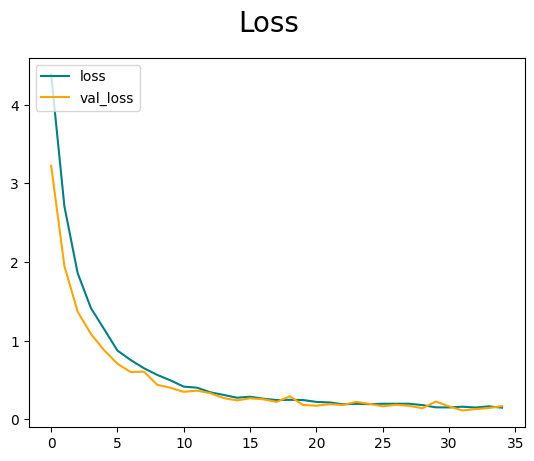

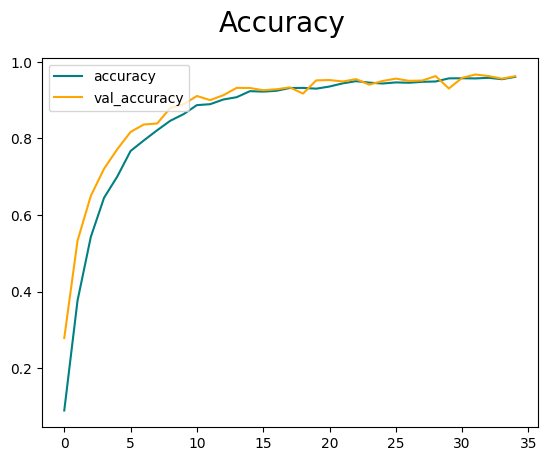

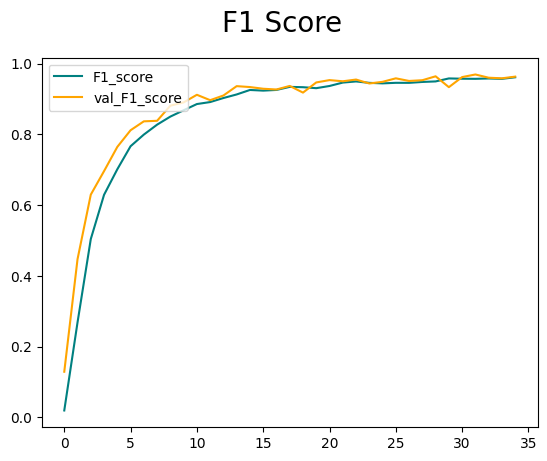

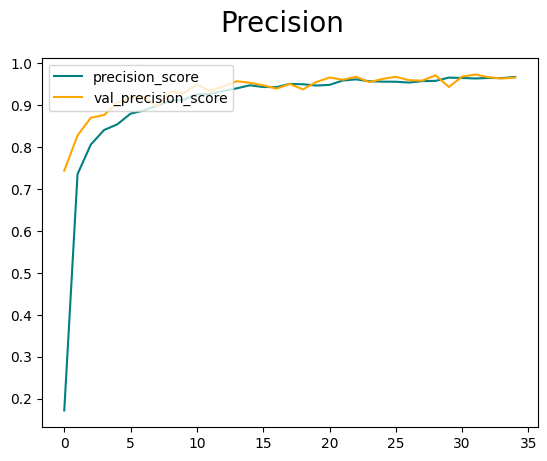

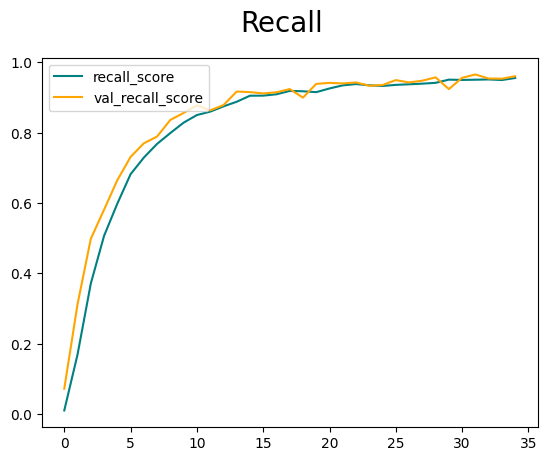

In [31]:
plot_history(hist=hist1c)

## Training Model 2

In [32]:
img_size2 = (64, 64, 3)
batch_siz2 = 32
num_classes = 151

In [33]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

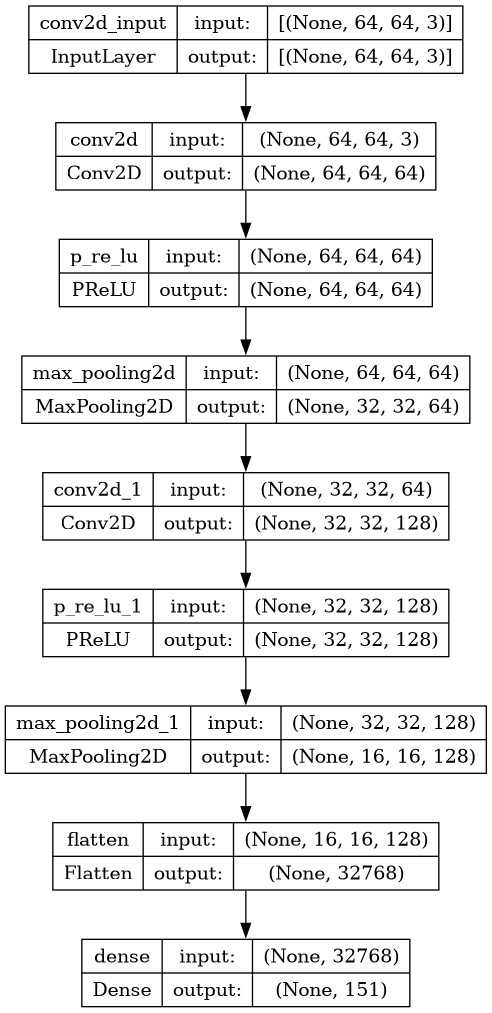

In [34]:
neuralnetwork_cnn2a = model_2a(img_size2, num_classes= 151)
neuralnetwork_cnn2a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn2a, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [35]:
neuralnetwork_cnn2b = model_2b(img_size2, num_classes= 151)
neuralnetwork_cnn2b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [36]:
neuralnetwork_cnn2c = model_2c(img_size2, num_classes= 151)
neuralnetwork_cnn2c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [37]:
hist2a , fil2a, es2a = train_model(model=neuralnetwork_cnn2a, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=21, 
                                num_epochs=35)

Epoch 1/35


/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.7522 - acc: 0.0369 - f1_m: 2.7674e-04 - precision_m: 0.0046 - recall_m: 1.4269e-04
Epoch 1: loss improved from inf to 4.75216, saving model to model21.h5
219/219 [==============================] - 77s 349ms/step - loss: 4.7522 - acc: 0.0369 - f1_m: 2.7674e-04 - precision_m: 0.0046 - recall_m: 1.4269e-04 - val_loss: 3.8921 - val_acc: 0.1398 - val_f1_m: 0.0141 - val_precision_m: 0.1776 - val_recall_m: 0.0074 - lr: 0.0020
Epoch 2/35


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 3.2585 - acc: 0.2479 - f1_m: 0.1381 - precision_m: 0.6553 - recall_m: 0.0802
Epoch 2: loss improved from 4.75216 to 3.25850, saving model to model21.h5
219/219 [==============================] - 85s 388ms/step - loss: 3.2585 - acc: 0.2479 - f1_m: 0.1381 - precision_m: 0.6553 - recall_m: 0.0802 - val_loss: 2.5042 - val_acc: 0.3973 - val_f1_m: 0.2488 - val_precision_m: 0.8526 - val_recall_m: 0.1488 - lr: 0.0020
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 2.2226 - acc: 0.4639 - f1_m: 0.3976 - precision_m: 0.7559 - recall_m: 0.2750
Epoch 3: loss improved from 3.25850 to 2.22256, saving model to model21.h5
219/219 [==============================] - 77s 352ms/step - loss: 2.2226 - acc: 0.4639 - f1_m: 0.3976 - precision_m: 0.7559 - recall_m: 0.2750 - val_loss: 1.8812 - val_acc: 0.5462 - val_f1_m: 0.4631 - val_precision_m: 0.7959 - val_recall_m: 0.3306 - lr: 0.0020
Epoch 4/35
219/219 [=========================

In [38]:
hist2b , fil2b, es2b = train_model(model=neuralnetwork_cnn2b, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=22, 
                                num_epochs=35)

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 5.0553 - acc: 0.0090 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: loss improved from inf to 5.05528, saving model to model22.h5
219/219 [==============================] - 80s 361ms/step - loss: 5.0553 - acc: 0.0090 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.8370 - val_acc: 0.0287 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 3.8108 - acc: 0.1590 - f1_m: 0.0566 - precision_m: 0.3874 - recall_m: 0.0312
Epoch 2: loss improved from 5.05528 to 3.81077, saving model to model22.h5
219/219 [==============================] - 86s 392ms/step - loss: 3.8108 - acc: 0.1590 - f1_m: 0.0566 - precision_m: 0.3874 - recall_m: 0.0312 - val_loss: 2.9148 - val_acc: 0.3236 - val_f1_m: 0.1743 - val_precision_m: 0.8375 - val_recall_m: 0.0991 - lr: 0.0020
Ep

In [39]:
hist2c , fil2c, es2c = train_model(model=neuralnetwork_cnn2c, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=23, 
                                num_epochs=35)

Epoch 1/35


/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.0241 - acc: 0.1257 - f1_m: 0.0407 - precision_m: 0.2598 - recall_m: 0.0230
Epoch 1: loss improved from inf to 4.02410, saving model to model23.h5
219/219 [==============================] - 86s 387ms/step - loss: 4.0241 - acc: 0.1257 - f1_m: 0.0407 - precision_m: 0.2598 - recall_m: 0.0230 - val_loss: 2.8115 - val_acc: 0.3249 - val_f1_m: 0.1658 - val_precision_m: 0.7926 - val_recall_m: 0.0950 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.4432 - acc: 0.4094 - f1_m: 0.3118 - precision_m: 0.7432 - recall_m: 0.2023
Epoch 2: loss improved from 4.02410 to 2.44318, saving model to model23.h5
219/219 [==============================] - 85s 388ms/step - loss: 2.4432 - acc: 0.4094 - f1_m: 0.3118 - precision_m: 0.7432 - recall_m: 0.2023 - val_loss: 2.0798 - val_acc: 0.4854 - val_f1_m: 0.4288 - val_precision_m: 0.8083 - val_recall_m: 0.2965 - lr: 0.0020
Epoch 3/35
219/219 [=============================

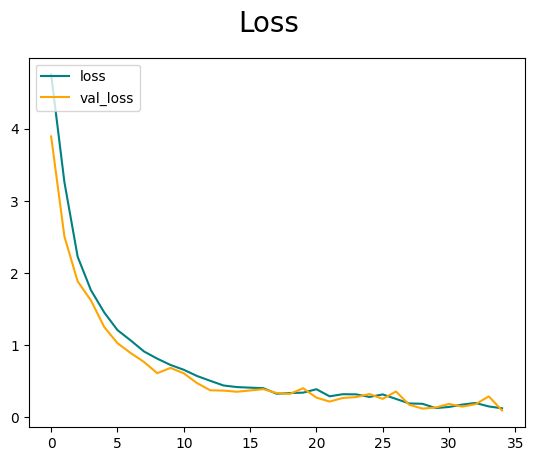

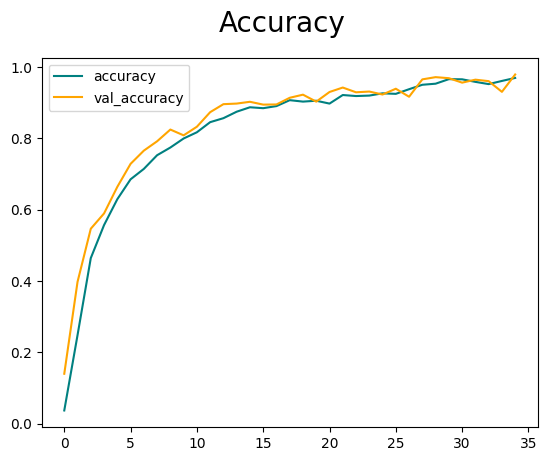

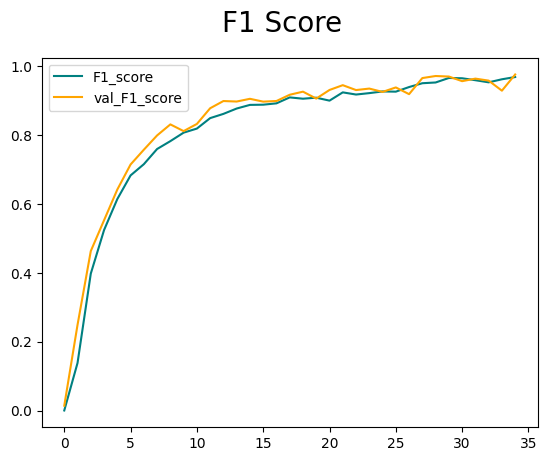

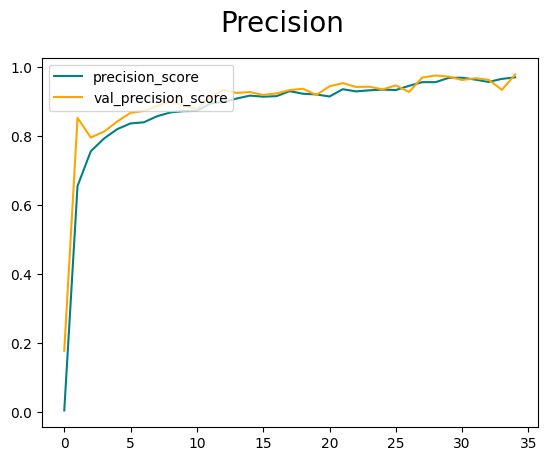

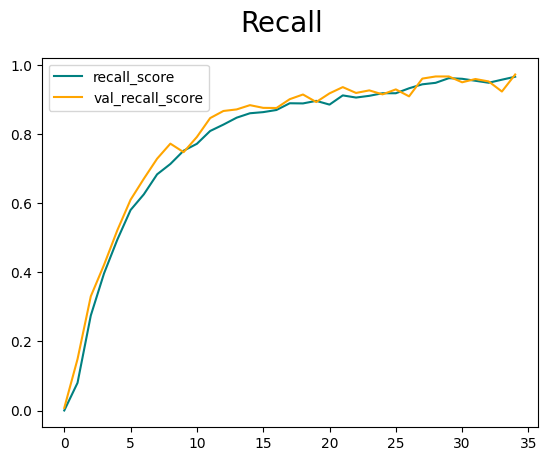

In [40]:
plot_history(hist=hist2a)

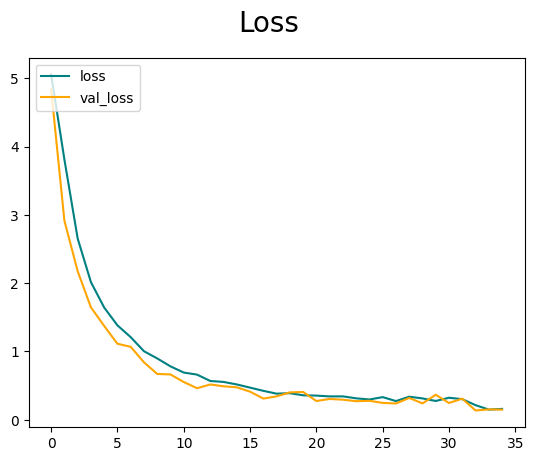

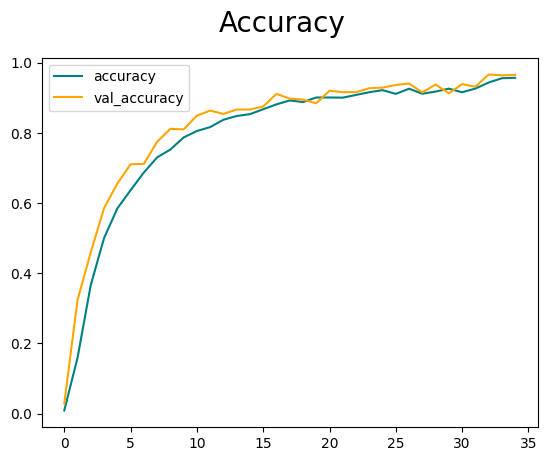

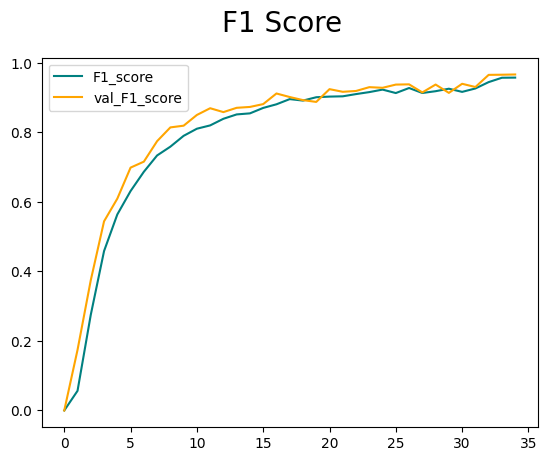

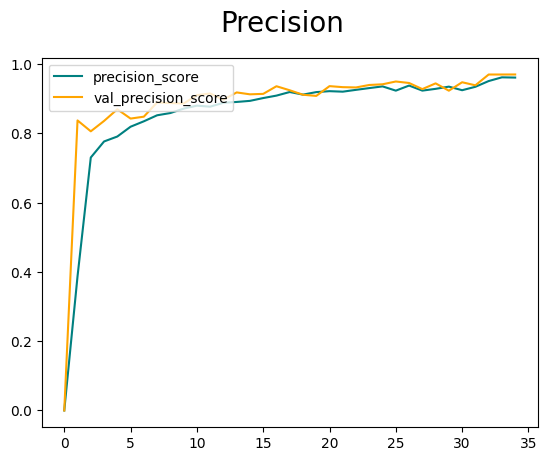

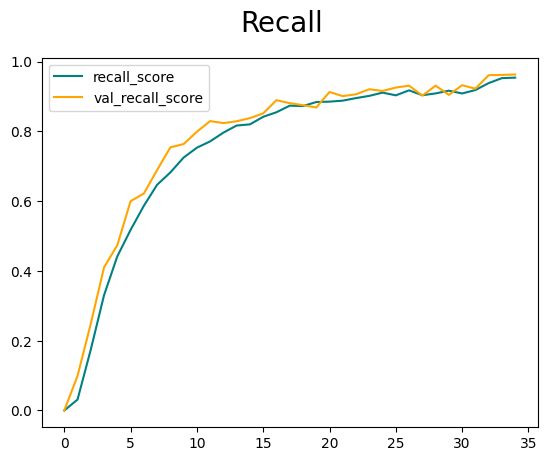

In [41]:
plot_history(hist=hist2b)

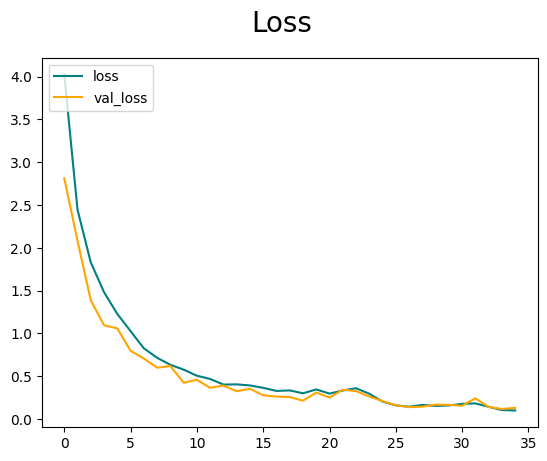

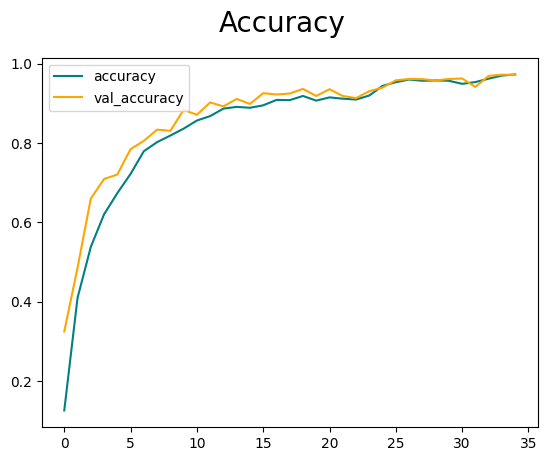

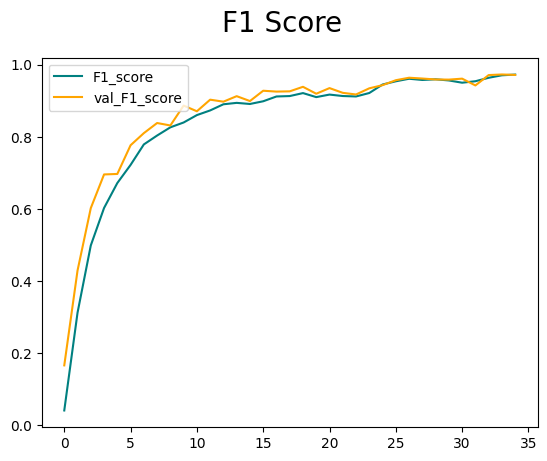

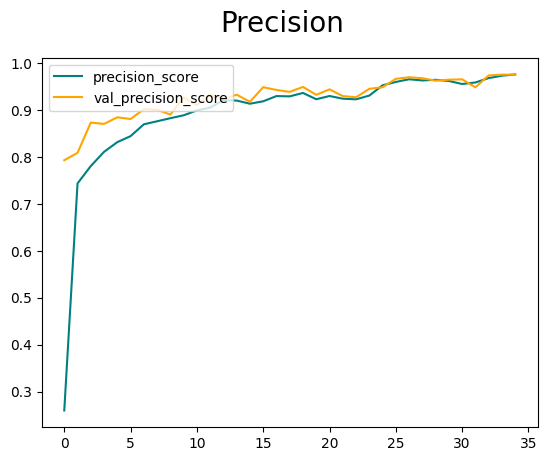

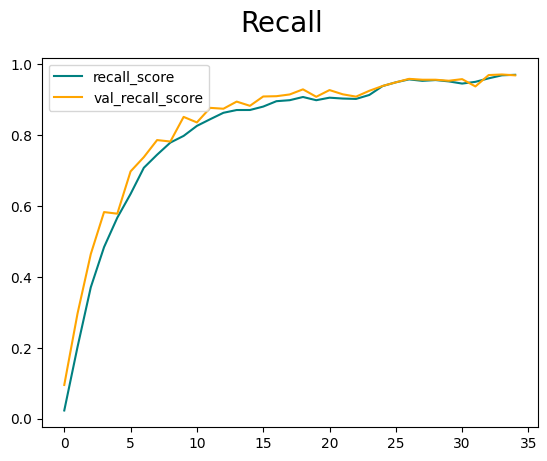

In [42]:
plot_history(hist=hist2c)

## Training Model 3

In [43]:
img_size3= (64, 64, 3)
batch_siz3 = 32
num_classes = 151

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

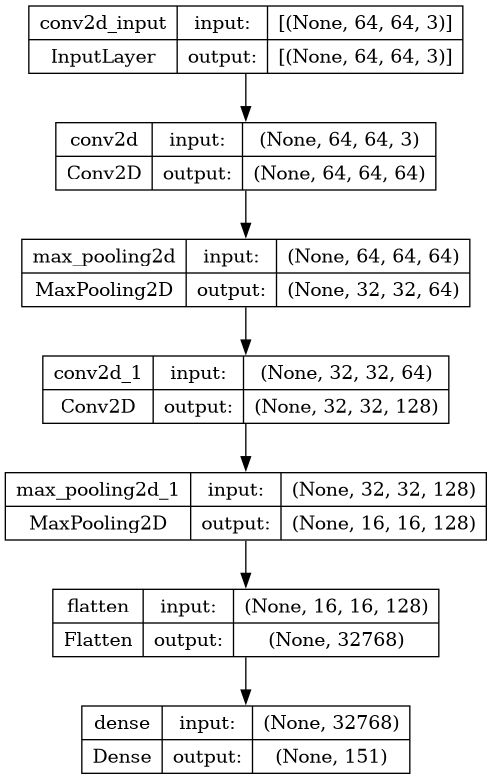

In [44]:
neuralnetwork_cnn3a = model_3a(img_size3, num_classes= 151)
neuralnetwork_cnn3a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn3a, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [45]:
neuralnetwork_cnn3b = model_3b(img_size3, num_classes= 151)
neuralnetwork_cnn3b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [46]:
neuralnetwork_cnn3c = model_3c(img_size3, num_classes= 151)
neuralnetwork_cnn3c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [47]:
train_set3 , val_set3 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size3,
                                  num_batch= batch_siz3)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [48]:
hist3a , fil3a, es3a = train_model(model=neuralnetwork_cnn3a, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=31, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 3.9108 - acc: 0.1821 - f1_m: 0.0923 - precision_m: 0.4170 - recall_m: 0.0539
Epoch 1: loss improved from inf to 3.91083, saving model to model31.h5
219/219 [==============================] - 80s 361ms/step - loss: 3.9108 - acc: 0.1821 - f1_m: 0.0923 - precision_m: 0.4170 - recall_m: 0.0539 - val_loss: 3.1528 - val_acc: 0.2974 - val_f1_m: 0.2303 - val_precision_m: 0.5853 - val_recall_m: 0.1464 - lr: 0.0020
Epoch 2/35


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.7805 - acc: 0.3776 - f1_m: 0.3209 - precision_m: 0.6755 - recall_m: 0.2144
Epoch 2: loss improved from 3.91083 to 2.78054, saving model to model31.h5
219/219 [==============================] - 87s 397ms/step - loss: 2.7805 - acc: 0.3776 - f1_m: 0.3209 - precision_m: 0.6755 - recall_m: 0.2144 - val_loss: 2.2268 - val_acc: 0.4784 - val_f1_m: 0.4393 - val_precision_m: 0.7664 - val_recall_m: 0.3125 - lr: 0.0020
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 2.2231 - acc: 0.4866 - f1_m: 0.4845 - precision_m: 0.7224 - recall_m: 0.3688
Epoch 3: loss improved from 2.78054 to 2.22309, saving model to model31.h5
219/219 [==============================] - 87s 397ms/step - loss: 2.2231 - acc: 0.4866 - f1_m: 0.4845 - precision_m: 0.7224 - recall_m: 0.3688 - val_loss: 1.7304 - val_acc: 0.5811 - val_f1_m: 0.5814 - val_precision_m: 0.8202 - val_recall_m: 0.4539 - lr: 0.0020
Epoch 4/35
219/219 [=========================

In [49]:
hist3b , fil3b, es3b = train_model(model=neuralnetwork_cnn3b, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=32, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 3.9578 - acc: 0.1733 - f1_m: 0.0869 - precision_m: 0.4140 - recall_m: 0.0505
Epoch 1: loss improved from inf to 3.95779, saving model to model32.h5
219/219 [==============================] - 89s 404ms/step - loss: 3.9578 - acc: 0.1733 - f1_m: 0.0869 - precision_m: 0.4140 - recall_m: 0.0505 - val_loss: 2.9232 - val_acc: 0.3299 - val_f1_m: 0.2332 - val_precision_m: 0.7086 - val_recall_m: 0.1427 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.7358 - acc: 0.3827 - f1_m: 0.3313 - precision_m: 0.6803 - recall_m: 0.2238
Epoch 2: loss improved from 3.95779 to 2.73585, saving model to model32.h5
219/219 [==============================] - 91s 412ms/step - loss: 2.7358 - acc: 0.3827 - f1_m: 0.3313 - precision_m: 0.6803 - recall_m: 0.2238 - val_loss: 2.4494 - val_acc: 0.4339 - val_f1_m: 0.4150 - val_precision_m: 0.7164 - val_recall_m: 0.2956 - lr: 0.0020
Epoch 3/35
219/219 [==================

In [50]:
hist3c , fil3c, es3c = train_model(model=neuralnetwork_cnn3c, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=33, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_18/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 3.8057 - acc: 0.1907 - f1_m: 0.0925 - precision_m: 0.3928 - recall_m: 0.0544
Epoch 1: loss improved from inf to 3.80571, saving model to model33.h5
219/219 [==============================] - 87s 390ms/step - loss: 3.8057 - acc: 0.1907 - f1_m: 0.0925 - precision_m: 0.3928 - recall_m: 0.0544 - val_loss: 2.5948 - val_acc: 0.4043 - val_f1_m: 0.2635 - val_precision_m: 0.7525 - val_recall_m: 0.1628 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.5655 - acc: 0.4102 - f1_m: 0.3588 - precision_m: 0.7128 - recall_m: 0.2431
Epoch 2: loss improved from 3.80571 to 2.56554, saving model to model33.h5
219/219 [==============================] - 90s 413ms/step - loss: 2.5655 - acc: 0.4102 - f1_m: 0.3588 - precision_m: 0.7128 - recall_m: 0.2431 - val_loss: 1.9004 - val_acc: 0.5549 - val_f1_m: 0.4959 - val_precision_m: 0.8189 - val_recall_m: 0.3606 - lr: 0.0020
Epoch 3/35
219/219 [==================

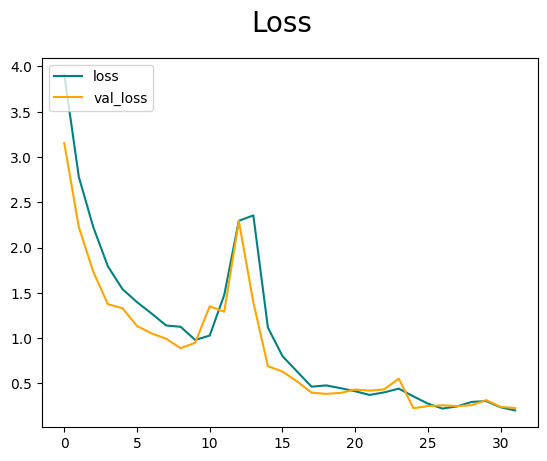

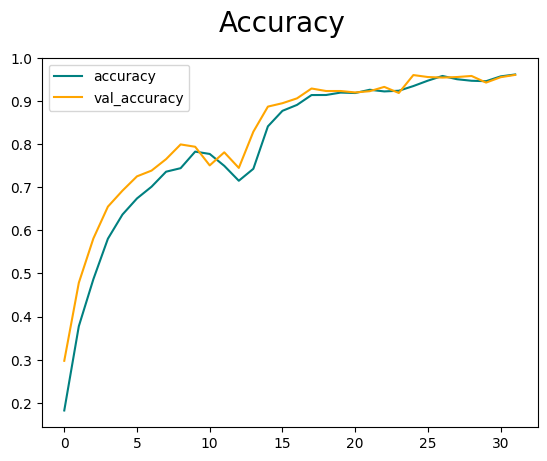

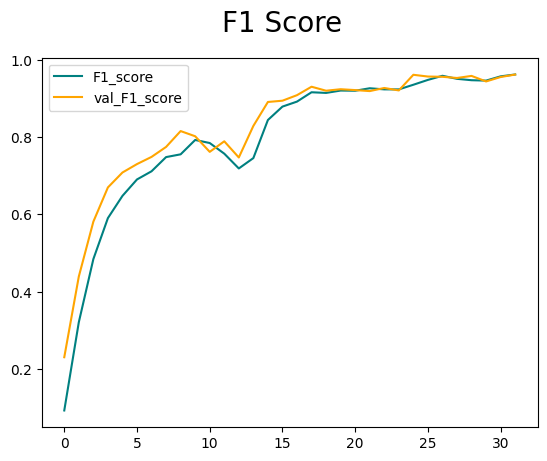

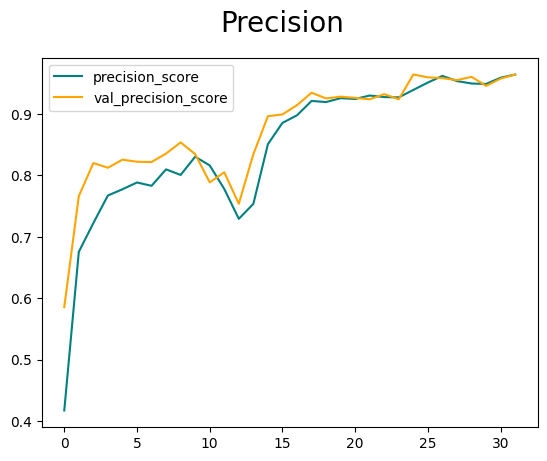

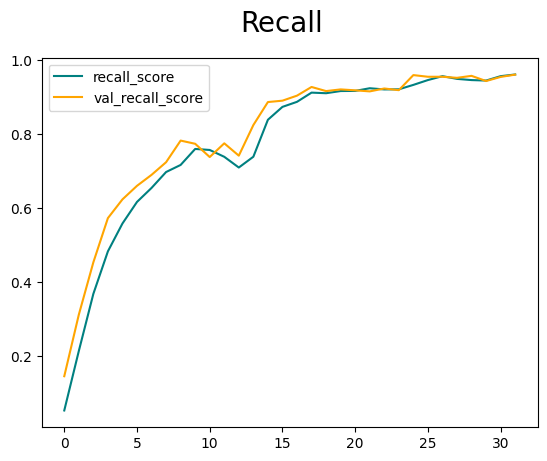

In [51]:
plot_history(hist=hist3a)

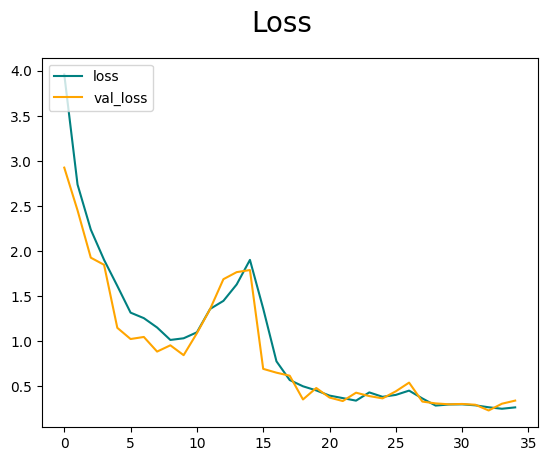

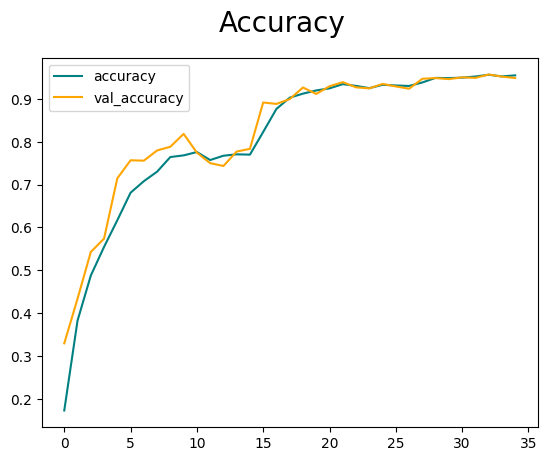

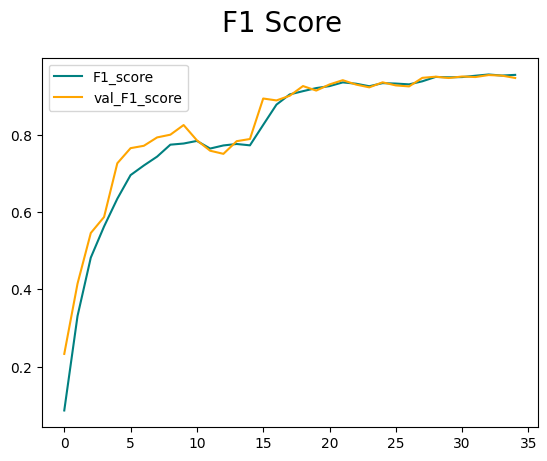

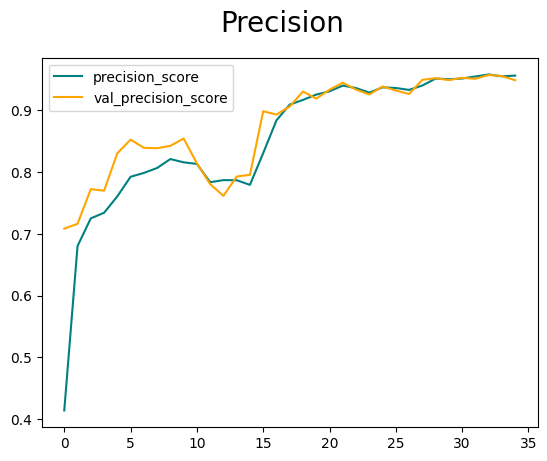

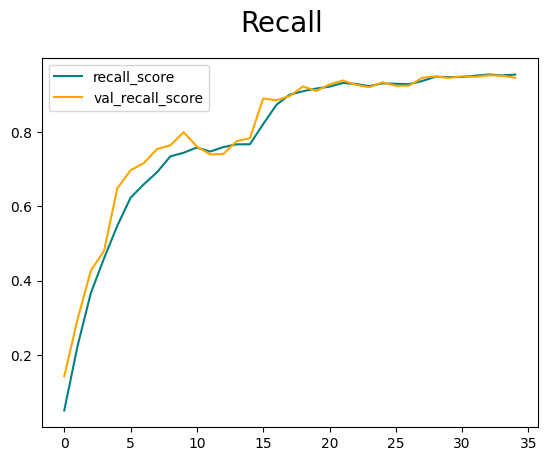

In [52]:
plot_history(hist=hist3b)

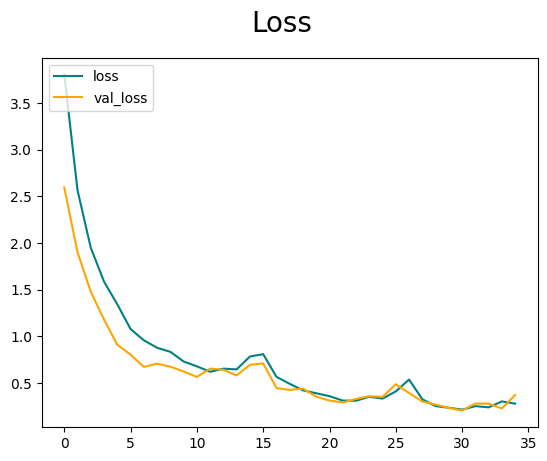

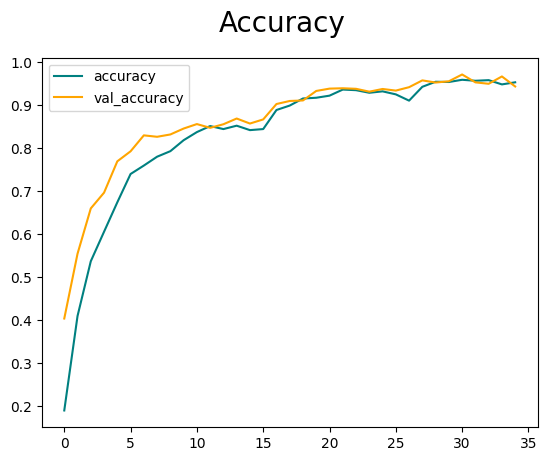

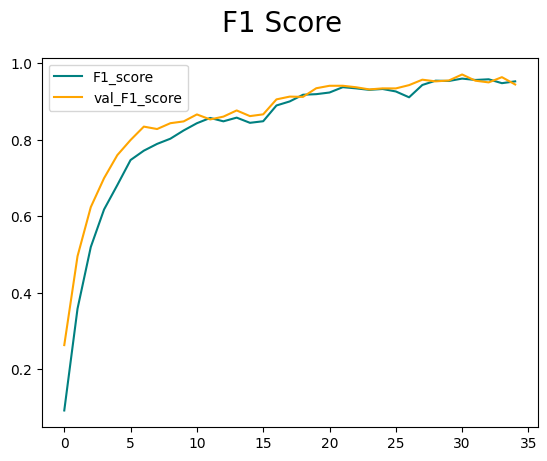

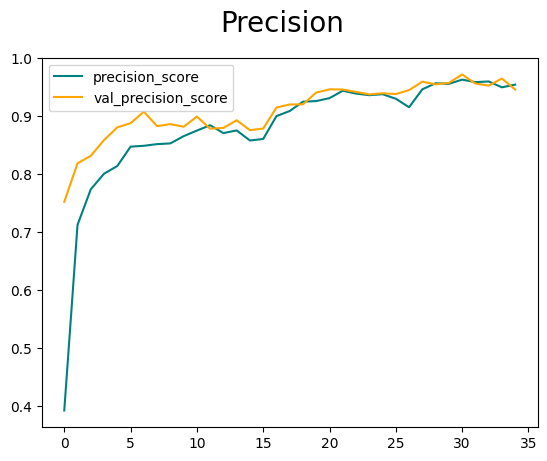

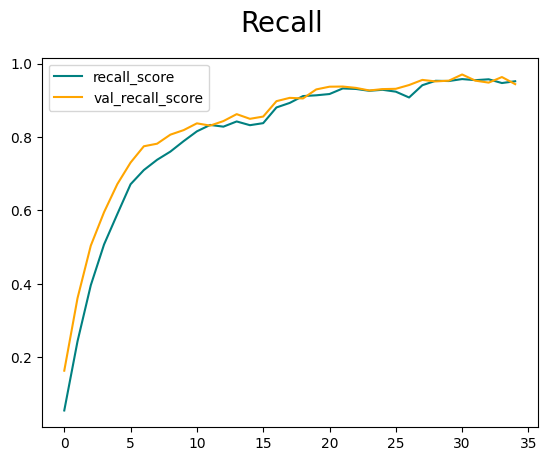

In [53]:
plot_history(hist=hist3c)

# Conclusion

We found that the weight decay term of AdamW affects the PReLU by fixing the otherwise variable $\alpha$ parameter, essentially making it behave more like a standard ReLU if fixed to 0, or a LeakyReLU for every other value.

With our dataset and under the conditions specified above, GELU performed rather poorly on this task. 

The NAdam optimizer performed better than Adam and AdamW across the board. This is because the Nesterov Momentum is proven to achieve convergence faster, ultimately smoothing any abrupt changes in metrics. This is noticeable with GELU more than other models.